In [11]:
# install our packages
library(dplyr)
library(boot)
library(pscl)
library(MASS)
library(ggplot2)
library(ggpubr)
library(lme4)
library(AER)
library(cowplot)

# # setwd()
# this.dir <- dirname(parent.frame(2)$ofile)
# setwd(this.dir)

In [12]:
spores_df <- read.csv("diet_supp_spore_data.csv")
str(spores_df)

'data.frame':	320 obs. of  8 variables:
 $ bee_code      : chr  "Hive1_EnI_1" "Hive1_EnI_10" "Hive1_EnI_11" "Hive1_EnI_12" ...
 $ treatment     : chr  "Nektapoll-Control" "Nektapoll-Control" "Nektapoll-Control" "Nektapoll-Control" ...
 $ infection     : chr  "Not-Infected" "Not-Infected" "Not-Infected" "Not-Infected" ...
 $ diet          : chr  "Supplemented" "Supplemented" "Supplemented" "Supplemented" ...
 $ hive          : int  1 1 1 1 1 1 1 1 1 1 ...
 $ susceptibility: int  0 0 0 0 0 0 0 0 0 0 ...
 $ spb           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ divided_10000 : int  0 0 0 0 0 0 0 0 0 0 ...


In [13]:
# convert hive, infection and diet to factors
spores_df$hive <- factor(spores_df$hive)
spores_df$infection <- factor(spores_df$infection)
spores_df$diet <- factor(spores_df$diet)
head(spores_df)

,bee_code,treatment,infection,diet,hive,susceptibility,spb,divided_10000
,<chr>,<chr>,<fct>,<fct>,<fct>,<int>,<int>,<int>
1,Hive1_EnI_1,Nektapoll-Control,Not-Infected,Supplemented,1,0,0,0
2,Hive1_EnI_10,Nektapoll-Control,Not-Infected,Supplemented,1,0,0,0
3,Hive1_EnI_11,Nektapoll-Control,Not-Infected,Supplemented,1,0,0,0
4,Hive1_EnI_12,Nektapoll-Control,Not-Infected,Supplemented,1,0,0,0
5,Hive1_EnI_13,Nektapoll-Control,Not-Infected,Supplemented,1,0,0,0
6,Hive1_EnI_14,Nektapoll-Control,Not-Infected,Supplemented,1,0,0,0


## 1. Inspect the data structure

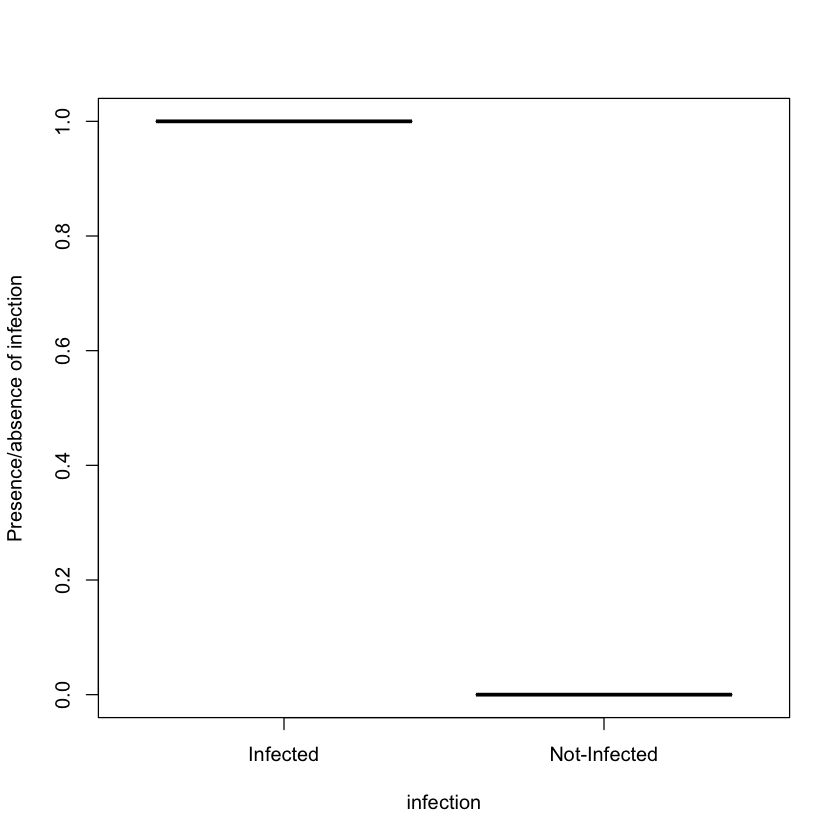

In [14]:
# no spores were found in bees that were not infected and all bees that were infected had spores
# therefore we see the distribution like this where presence of nosema is completely explained by Infection
infection.susceptibilityboxplot <- plot(susceptibility ~ infection, data = spores_df, 
                                 ylab = "Presence/absence of infection")

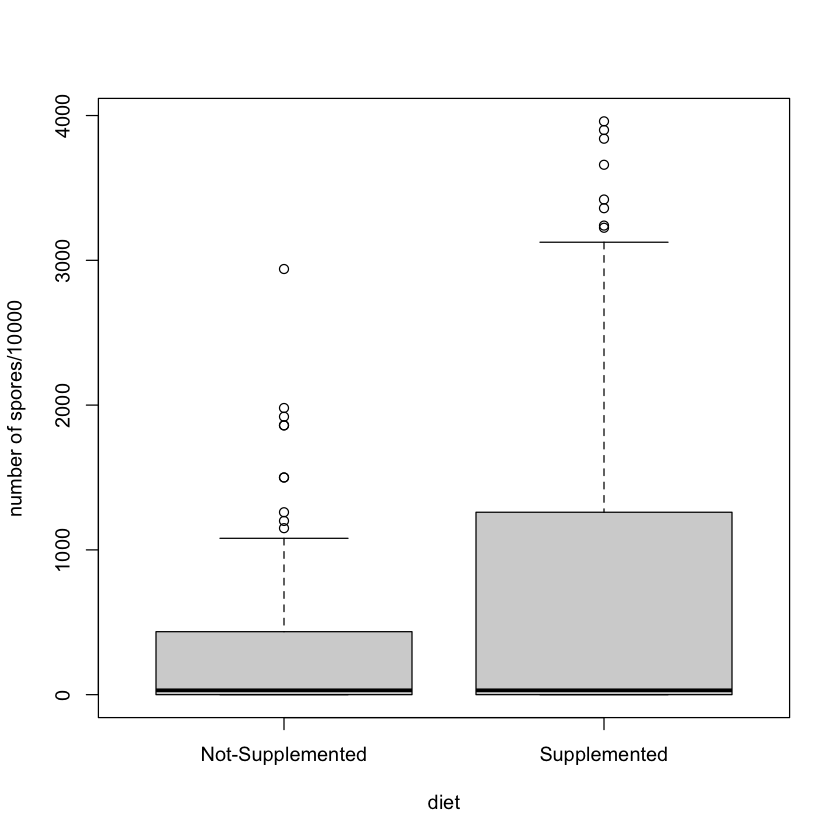

In [19]:
diet.sporesboxplot <- boxplot(divided_10000 ~ diet, data = spores_df, ylab = "number of spores/10000")
# this plot includes both infected and non-infected treatments and so both have lots of zeros, although
# it seems supplemented bees have higher spores

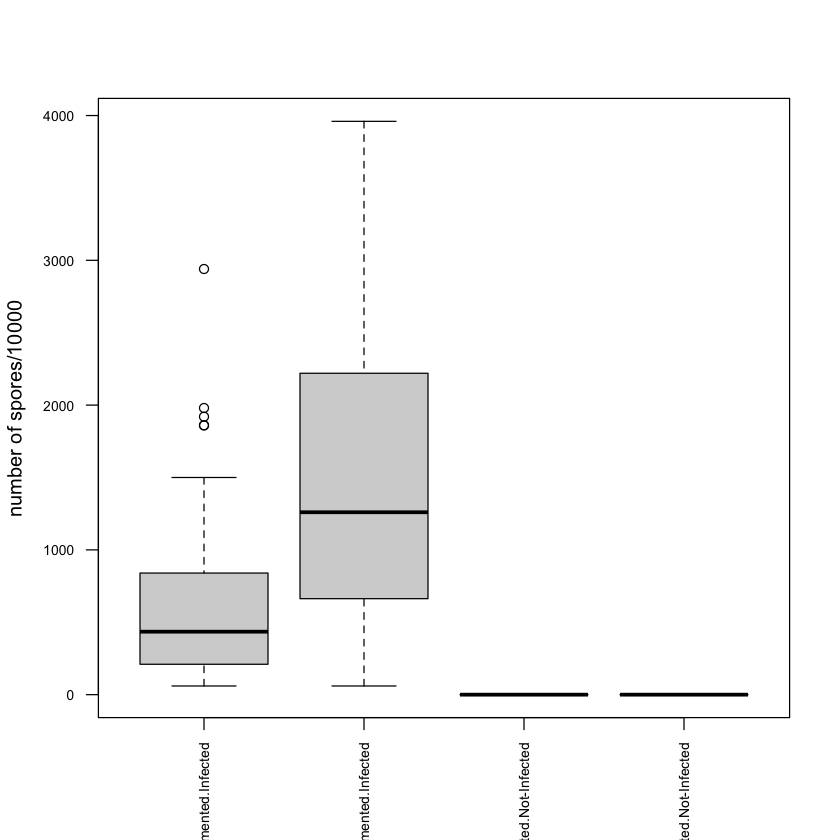

In [20]:
diet.by.infection.sporesboxplot <- boxplot(divided_10000 ~ diet*infection, data = spores_df, 
                                           ylab = "number of spores/10000", las = 2, xlab = "", 
                                           par(cex.axis =0.7))
# shows that when bees are infected, those supplemented with Nektapoll tend to have higher spores
# those not-infected have none, as we have shown already

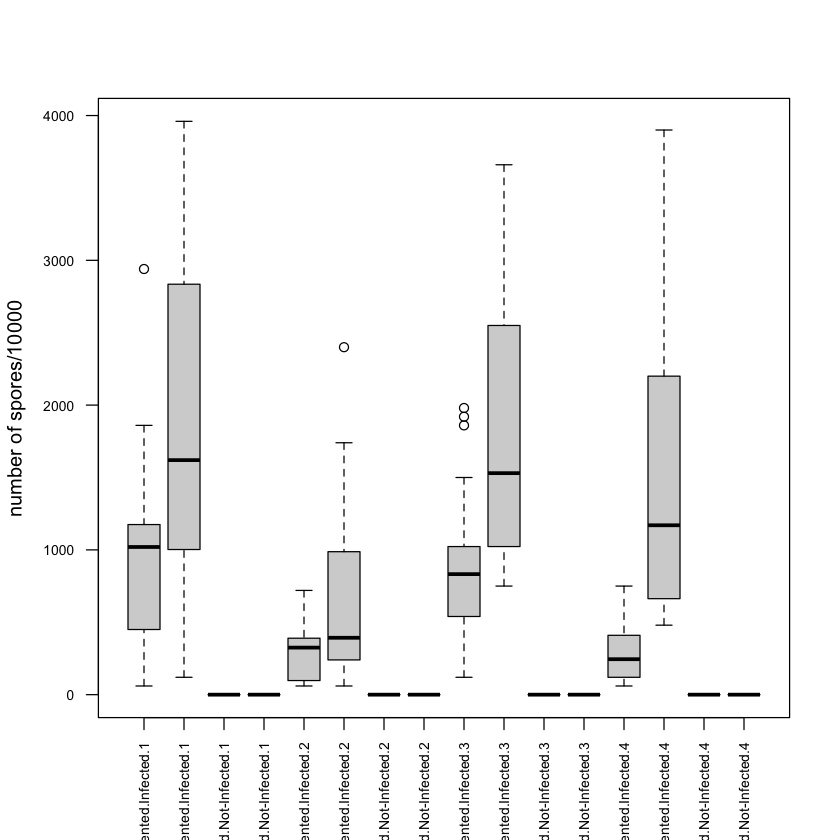

In [21]:
diet.by.infection.by.hive.spores <- boxplot(divided_10000 ~ diet*infection*hive, data = spores_df, 
                                            ylab = "number of spores/10000", las = 2, xlab = "", 
                                            par(cex.axis =0.7))
# as expected, supplemented bees have higher spores when compared to non-supplemented of the same hive
# although hive 2 appears to have lower than the others

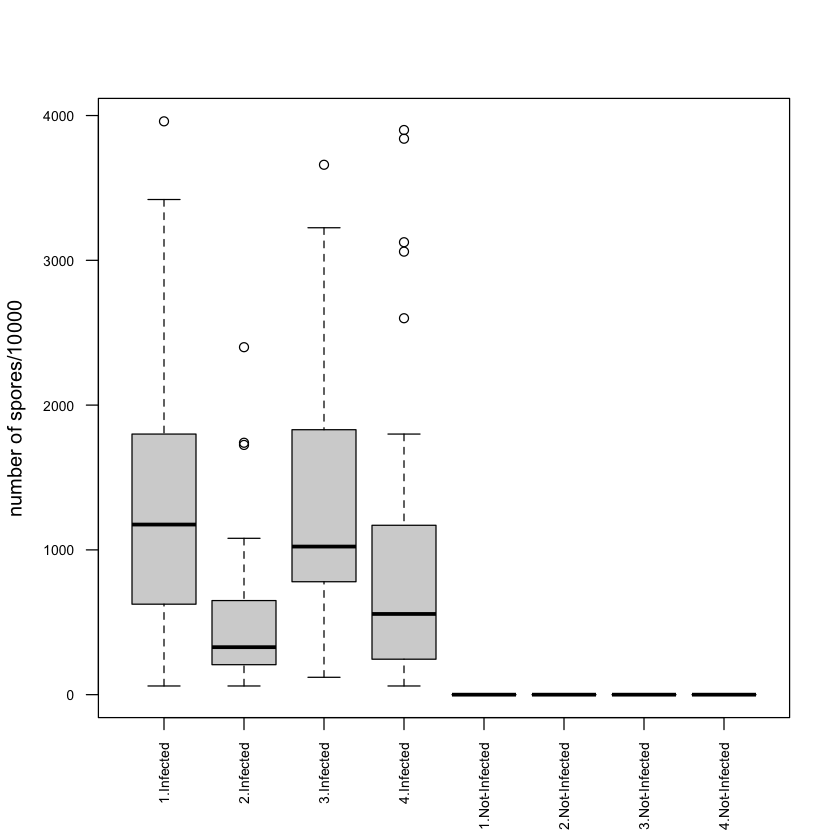

In [22]:
hive.by.infection.sporesboxplot <- boxplot(divided_10000 ~ hive*infection, data = spores_df, 
                                           ylab = "number of spores/10000", las = 2, xlab = "", 
                                           par(cex.axis =0.7))
# hives 1 and 3 have similar, hive 4 is medium and hive 2 has the lowest, could be a hive effect

## 2. Selecting a model

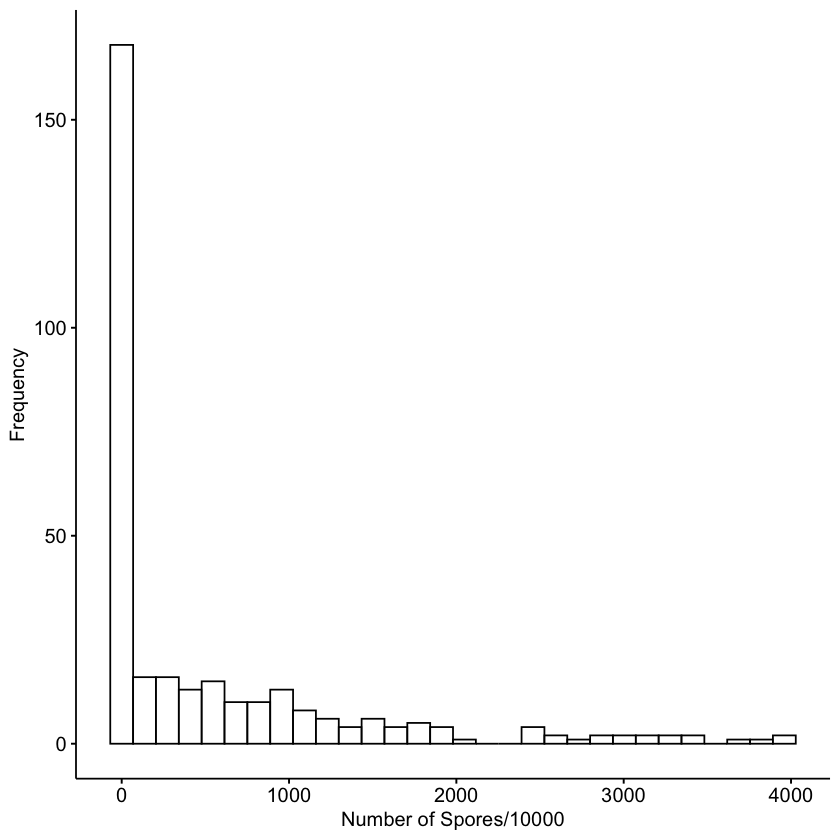

In [23]:
# to select our model we need to plot the distribution of the data
dist.hist <- gghistogram(spores_df, x = "divided_10000", y = "..count..", palette = 'npg', bins = 30,
                                                   xlab = "Number of Spores/10000", ylab = "Frequency")
dist.hist

#### Zero inflation
Huge zero inflation zero-inflated count data is run with NB models rather than poisson,but all of my zeros are structural rather than sampling zeros (i.e. they werent because I found zeros as part of the sampling variation, but zeros were dependent on Infection, as shown in boxplot). This means that I can't use a normal NB model as this would treat these zeros as part of the normal sampling distribution, which they are not. I'll therfore split the analysis between infection prevalence and spore intensity. I will test the prevalence of infection, then only run spore analysis on bees that actually have spores. Like a hurdle model

### 2a. Modelling the susceptibility of infection

In [24]:
# logistic regression model
supplementation_prevalence <- glm(susceptibility ~ infection, data = spores_df,
                            family = binomial)
# warning that the model did not converge, likely because of complete separation as susceptibility is completely
# explained by whether the bees were infected

Warning message:
“glm.fit: algorithm did not converge”


In [25]:
# try fisher's exact test
# convert 0/1 to no/yes to create contingency table
supplementation_fisher <- spores_df %>% mutate(susceptibility = ifelse(susceptibility == "0","No","Yes"))
supplementation_fisher$susceptibility <- factor(supplementation_fisher$susceptibility)
fishers_table <- table(supplementation_fisher$infection, supplementation_fisher$susceptibility)
fishers_table

              
                No Yes
  Infected       0 160
  Not-Infected 160   0

In [26]:
fisher.test(fishers_table, conf.int = TRUE, conf.level = 0.95)


	Fisher's Exact Test for Count Data

data:  fishers_table
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.0000000000 0.0003433315
sample estimates:
odds ratio 
         0 


### 2b. Modelling the number of spores 
we have already established that no spores will occur in non-infected bees, so these will be taken out of the following analysis. Essentially, what we are showing now is that in bees that are infected, how do supplements or hive effect the number of spores present

In [27]:
# Lets remove zeros from the the data
infected_only_spores_df <- subset(spores_df, infection == "Infected")

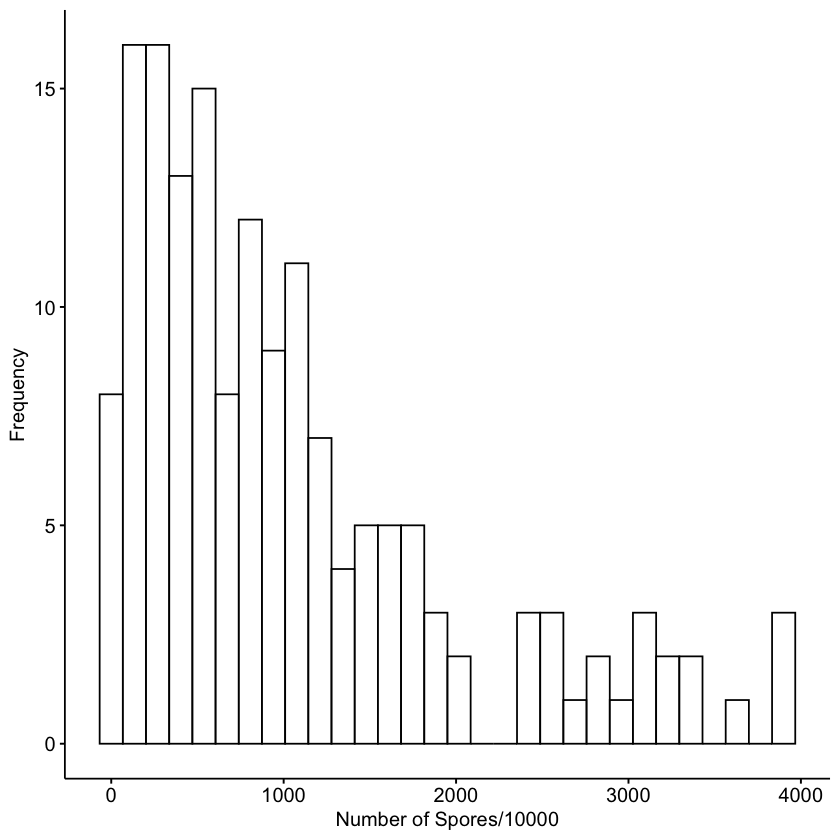

In [29]:
# let's take a look at the distribution
infected_only_dist <- gghistogram(infected_only_spores_df, x = "divided_10000", y = "..count..", bins = 30, 
            palette = 'npg', xlab = "Number of Spores/10000", ylab = "Frequency")
infected_only_dist
# will be a poisson or nb distribution

In [36]:
# running a glmm, first I will run with all the factors and stepwise take them off by looking at AICs and whether
# the factor is significan
diet.hive.supplement.mod <- glmer(divided_10000 ~ diet + (1|hive), data = infected_only_spores_df, family = "poisson")
summary(diet.hive.supplement.mod)
# output shows that supplemented bees have higher spore levels on average

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: divided_10000 ~ diet + (1 | hive)
   Data: infected_only_spores_df

     AIC      BIC   logLik deviance df.resid 
 73330.9  73340.1 -36662.4  73324.9      157 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-42.072 -16.380  -5.749   9.241  74.290 

Random effects:
 Groups Name        Variance Std.Dev.
 hive   (Intercept) 0.1653   0.4066  
Number of obs: 160, groups:  hive, 4

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      6.329369   0.203355   31.12   <2e-16 ***
dietSupplemented 0.896918   0.005397  166.18   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
ditSpplmntd -0.019

In [37]:
# run without hive as random factor and compare models
dietonly.supplement.mod <- glm(divided_10000 ~ diet, data = infected_only_spores_df, family = "poisson")
summary(dietonly.supplement.mod)
# AIC in original model is far lower, so we will stick with the original model


Call:
glm(formula = divided_10000 ~ diet, family = "poisson", data = infected_only_spores_df)

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      6.403698   0.004549  1407.7   <2e-16 ***
dietSupplemented 0.896918   0.005397   166.2   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 124262  on 159  degrees of freedom
Residual deviance:  93808  on 158  degrees of freedom
AIC: 95141

Number of Fisher Scoring iterations: 5


In [44]:
# check for overdispersion
dispersiontest(dietonly.supplement.mod)



	Overdispersion test

data:  dietonly.supplement.mod
z = 7.444, p-value = 4.883e-14
alternative hypothesis: true dispersion is greater than 1
sample estimates:
dispersion 
  616.4868 


In [46]:
negbin.diet.hive.supplementation.mod <- glmer.nb(divided_10000 ~ diet + (1|hive), data = infected_only_spores_df)
summary(negbin.diet.hive.supplementation.mod)
# much lower AIC

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Negative Binomial(1.8198)  ( log )
Formula: divided_10000 ~ diet + (1 | hive)
   Data: infected_only_spores_df

     AIC      BIC   logLik deviance df.resid 
  2476.9   2489.2  -1234.5   2468.9      156 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2718 -0.7877 -0.2364  0.4415  3.6160 

Random effects:
 Groups Name        Variance Std.Dev.
 hive   (Intercept) 0.1754   0.4188  
Number of obs: 160, groups:  hive, 4

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)        6.2782     0.2256  27.827  < 2e-16 ***
dietSupplemented   0.9732     0.1199   8.115 4.85e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
ditSpplmntd -0.267

In [47]:
exp(0.9732)

[1] 2.646399

In [48]:
exp(confint(negbin.diet.hive.supplementation.mod))

Computing profile confidence intervals ...



,2.5 %,97.5 %
.sig01,1.242759,2.888285
(Intercept),303.556408,931.523708
dietSupplemented,2.091727,3.348730


In [49]:
ranef(negbin.diet.hive.supplementation.mod)

$hive
  (Intercept)
1   0.3874863
2  -0.5411911
3   0.3445346
4  -0.1907627

with conditional variances for “hive” 

In [50]:
Anova(negbin.diet.hive.supplementation.mod)

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
diet,65.85501,1,4.853443e-16


In [52]:
# take Hive out and see if it makes a difference, but I think this model will be better as hive seems to 
# have a large effect and was better in the poisson model
negbin.dietonly.supplementation.mod <- glm.nb(divided_10000 ~ diet, data = infected_only_spores_df)
summary(negbin.dietonly.supplementation.mod)


Call:
glm.nb(formula = divided_10000 ~ diet, data = infected_only_spores_df, 
    init.theta = 1.458445966, link = log)

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)       6.40370    0.09269  69.087  < 2e-16 ***
dietSupplemented  0.89692    0.13104   6.845 7.66e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.4584) family taken to be 1)

    Null deviance: 222.85  on 159  degrees of freedom
Residual deviance: 177.48  on 158  degrees of freedom
AIC: 2506.5

Number of Fisher Scoring iterations: 1


              Theta:  1.458 
          Std. Err.:  0.149 

 2 x log-likelihood:  -2500.460 

In [53]:
# higher AIC than the random model, so we will go with negbin.diet.hive.supplementation.mod
anova(negbin.diet.hive.supplementation.mod, negbin.dietonly.supplementation.mod)
# anova shows that models are significantly different and so Hive is a significant random factor

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
negbin.dietonly.supplementation.mod,3,2506.460,2515.686,-1250.230,2500.460,NA,NA,NA
negbin.diet.hive.supplementation.mod,4,2476.914,2489.215,-1234.457,2468.914,31.54609,1,1.947623e-08


In [54]:
Anova(negbin.diet.hive.supplementation.mod)
# significantly different from the null model

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
diet,65.85501,1,4.853443e-16


## 3. Plotting our findings
We have shown that a NB GLMM with hive as a random factor is the best model to predict the number of spores in infected bees with supplemented diets. We showed that diet supplementation increased spore load by a factor of 2.65 ± 1.13 (n = 160, GLMM negative-binomial: Estimate = 0.97 ± 0.12, z = 8.11, P < 0.001). And that on average, infected bees fed with an enriched diet had 14.1 (exp(0.9732) * exp(6.2782)) million spores, which is significantly higher than the 5.3 million spores found in bees fed on a standard sucrose diet (P < 0.001). The random effect of hive accounted for significant variation in spore load (χ 2 = 31.55, d.f. = 1, P < 0.001), indicating that the intensity of Nosema spp. infection can vary between hives.

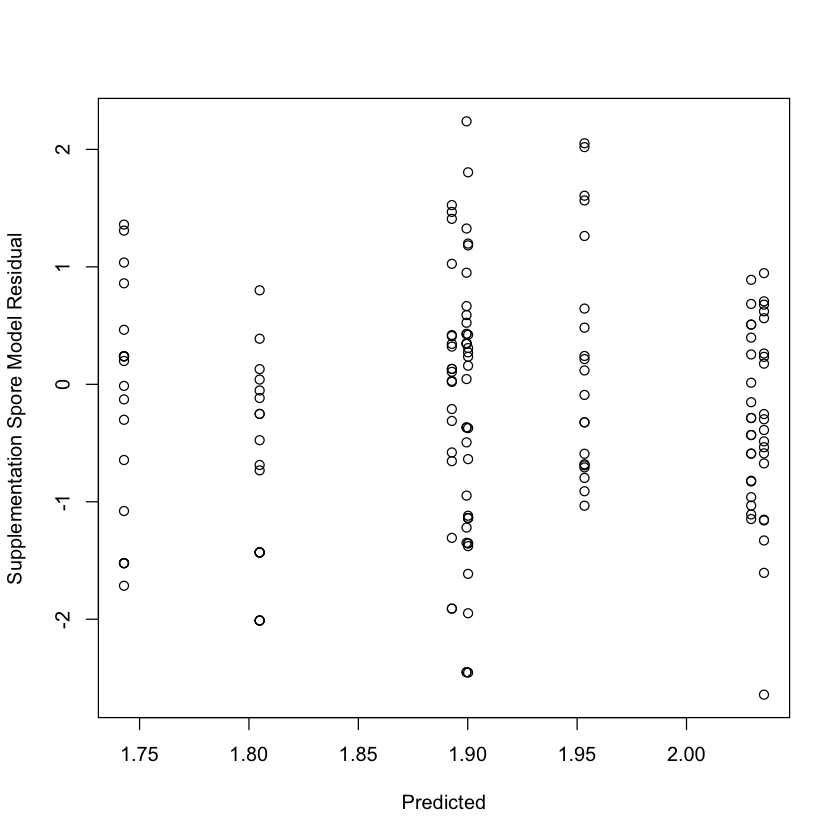

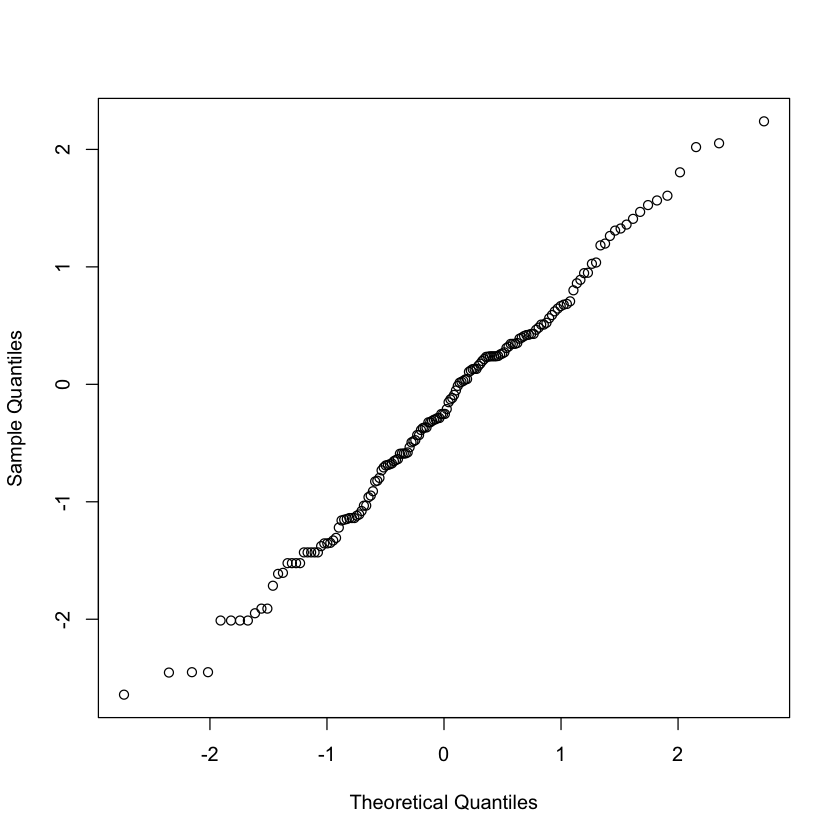

In [55]:
# create residual and qqnorm plots
supplementation.spore.validation <- residuals(negbin.diet.hive.supplementation.mod, type="deviance")
plot(log(predict(negbin.diet.hive.supplementation.mod)), supplementation.spore.validation, ylab = "Supplementation Spore Model Residual", 
     xlab = "Predicted")
qqnorm(supplementation.spore.validation, main = "")

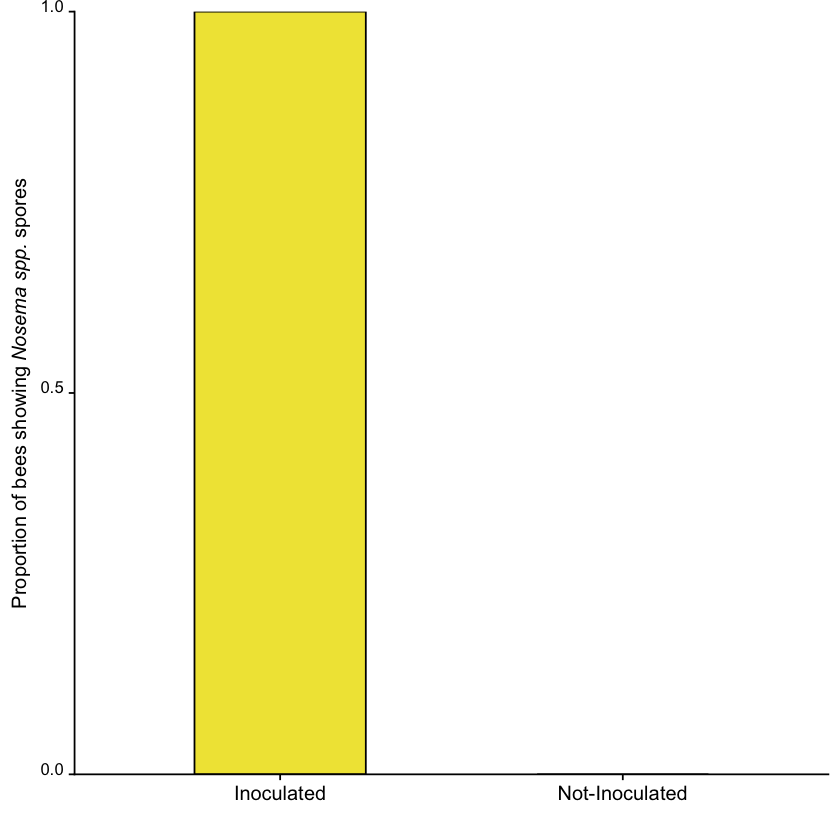

In [71]:
# starting with the logistic stuff, run a bar chart of infected and non-infected bees and susceptibility to nosema
# to express levels of infection as a proportion I have divided by 160

susceptibility.barchart <- ggplot(spores_df, aes(x = infection, y = susceptibility/160, fill = infection)) + 
stat_summary(fun=sum,geom="bar",colour="black", width = 0.5) + guides(fill = "none") + 
scale_fill_manual(values = c("#F0E442", "#0072B2", "#D55E00")) + theme_cowplot() + 
theme(legend.position = "none") + ylab("Proportion of bees showing"~italic("Nosema spp.")~"spores") + xlab("") + 
scale_x_discrete(labels = c("Inoculated", "Not-Inoculated")) + 
theme(axis.text.x = element_text(face = "plain",size = 12,vjust = 0.99, colour = "black"), axis.text.y = element_text(face="plain", size = 10, angle = 0, vjust = 0.0, hjust = 0.5, colour = "black")) + 
theme(text = element_text(size = 12)) + scale_y_continuous(limits = c(0,1), expand = c(0,0), breaks = seq(0,1, by = 0.5))
susceptibility.barchart

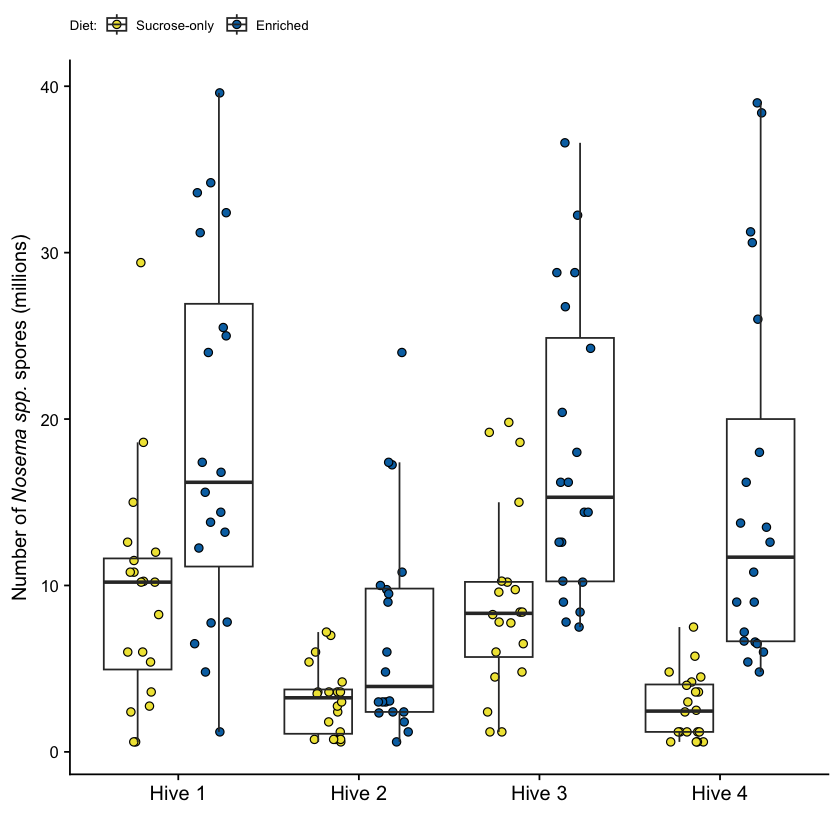

In [74]:
# now a boxplot to show difference between supplemented and non-supplemented treatments

b <- ggplot(data = infected_only_spores_df, aes(x = hive, y = spb/1000000, fill = diet))
supplementation.boxplot <- b + geom_point(aes(fill = diet), size = 2, shape = 21, position = position_jitterdodge()) + geom_boxplot(position = position_dodge(0.9), alpha = 0) + theme_cowplot() + 
  theme(legend.position = "top") + ylab("Number of"~italic("Nosema spp.")~"spores (millions)") + scale_x_discrete(labels = c("Hive 1", "Hive 2", "Hive 3", "Hive 4")) + 
  theme(legend.text=element_text(size=8), legend.title=element_text(size=8)) + guides(fill=guide_legend(title="Diet:")) + xlab("") + theme(text = element_text(size=12), axis.text.y = element_text(size = 10)) + 
  scale_fill_manual(values=c("#F0E442", "#0072B2"), labels = c("Sucrose-only", "Enriched"))
supplementation.boxplot